In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append('..')

import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
inputs = [12, 18, 24, 30]

In [9]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [11]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)
y_test = test.values

## Phase 1: generate predictions

In [10]:
np.seterr(all='ignore')

def get_last_N(series, N=18):
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [11]:
X_test_30 = np.array([get_last_N(ser[1], N=30) for ser in train.iterrows()])
X_test_24 = np.array([get_last_N(ser[1], N=24) for ser in train.iterrows()])
X_test_18 = np.array([get_last_N(ser[1], N=18) for ser in train.iterrows()])
X_test_12 = np.array([get_last_N(ser[1], N=12) for ser in train.iterrows()])

X_all = {12: X_test_12, 18: X_test_18, 24: X_test_24, 30: X_test_30}

In [12]:
def get_predictions(model, data):
        
    x = data[..., np.newaxis]
    
    mn, mx = x.min(axis=1), x.max(axis=1)
    x_sc = (x[..., 0] - mn) / (mx - mn)

    pred = model(x_sc[..., np.newaxis])

    return pred[..., 0] * (mx - mn) + mn

In [44]:
def ensemble_preds(model_family, data):

    preds = []
    
    model_dirs = [model_family + '__{}/best_weights.h5'.format(i) for i in range(60)]
    
    for model_dir in tqdm(model_dirs):

        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})
        preds.append(get_predictions(model, data))

        tf.keras.backend.clear_session()

    return np.stack(preds)

In [55]:
for i in inputs:
    for o in range(6, i+7, 2):
        print('inp: {}  out: {}'.format(i, o))
        family = '../results/final/inp_{}__out_{}__aug_0.95__loss_mae__bksize_700__bkact_relu__dir_conv4__ksize_5__opt_adam__lr_0.001'.format(i, o)
        preds = ensemble_preds(family, X_all[i])
        np.save('../predictions/final/inp_{}_out_{}'.format(i, o), preds)


  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 6



100%|██████████| 60/60 [01:18<00:00,  1.30s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 8



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 10



100%|██████████| 60/60 [01:57<00:00,  1.96s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 12



100%|██████████| 60/60 [02:24<00:00,  2.41s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 14



100%|██████████| 60/60 [01:28<00:00,  1.48s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 16



100%|██████████| 60/60 [02:10<00:00,  2.17s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 12  out: 18



100%|██████████| 60/60 [01:54<00:00,  1.91s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 6



100%|██████████| 60/60 [01:39<00:00,  1.66s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 8



100%|██████████| 60/60 [01:53<00:00,  1.88s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 10



100%|██████████| 60/60 [01:35<00:00,  1.59s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 12



100%|██████████| 60/60 [02:15<00:00,  2.26s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 14



100%|██████████| 60/60 [01:26<00:00,  1.44s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 16



100%|██████████| 60/60 [01:55<00:00,  1.92s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 18



100%|██████████| 60/60 [02:09<00:00,  2.15s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 20



100%|██████████| 60/60 [01:46<00:00,  1.77s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 22



100%|██████████| 60/60 [02:04<00:00,  2.08s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 18  out: 24



100%|██████████| 60/60 [01:37<00:00,  1.62s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 6



100%|██████████| 60/60 [01:14<00:00,  1.24s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 8



100%|██████████| 60/60 [01:23<00:00,  1.39s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 10



100%|██████████| 60/60 [01:24<00:00,  1.41s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 12



100%|██████████| 60/60 [01:25<00:00,  1.42s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 14



100%|██████████| 60/60 [01:30<00:00,  1.51s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 16



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 18



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 20



100%|██████████| 60/60 [01:29<00:00,  1.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 22



100%|██████████| 60/60 [01:36<00:00,  1.61s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 24



100%|██████████| 60/60 [01:31<00:00,  1.53s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 26



100%|██████████| 60/60 [01:37<00:00,  1.63s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 28



100%|██████████| 60/60 [02:04<00:00,  2.08s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 24  out: 30



100%|██████████| 60/60 [01:34<00:00,  1.58s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 6



100%|██████████| 60/60 [01:14<00:00,  1.25s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 8



100%|██████████| 60/60 [01:23<00:00,  1.39s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 10



100%|██████████| 60/60 [01:29<00:00,  1.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 12



100%|██████████| 60/60 [01:29<00:00,  1.48s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 14



100%|██████████| 60/60 [01:30<00:00,  1.50s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 16



100%|██████████| 60/60 [01:31<00:00,  1.52s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 18



100%|██████████| 60/60 [01:38<00:00,  1.64s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 20



100%|██████████| 60/60 [01:36<00:00,  1.61s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 22



100%|██████████| 60/60 [01:37<00:00,  1.62s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 24



100%|██████████| 60/60 [01:38<00:00,  1.63s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 26



100%|██████████| 60/60 [01:34<00:00,  1.58s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 28



100%|██████████| 60/60 [01:41<00:00,  1.69s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 30



100%|██████████| 60/60 [01:38<00:00,  1.64s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 32



100%|██████████| 60/60 [01:45<00:00,  1.76s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 34



100%|██████████| 60/60 [01:40<00:00,  1.67s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

inp: 30  out: 36



100%|██████████| 60/60 [01:40<00:00,  1.68s/it]


## Phase 2: evaluate predictions

In [4]:
!ls ../predictions/final

inp_12_out_10.npy  inp_18_out_20.npy  inp_24_out_24.npy  inp_30_out_22.npy
inp_12_out_12.npy  inp_18_out_22.npy  inp_24_out_26.npy  inp_30_out_24.npy
inp_12_out_14.npy  inp_18_out_24.npy  inp_24_out_28.npy  inp_30_out_26.npy
inp_12_out_16.npy  inp_18_out_6.npy   inp_24_out_30.npy  inp_30_out_28.npy
inp_12_out_18.npy  inp_18_out_8.npy   inp_24_out_6.npy	 inp_30_out_30.npy
inp_12_out_6.npy   inp_24_out_10.npy  inp_24_out_8.npy	 inp_30_out_32.npy
inp_12_out_8.npy   inp_24_out_12.npy  inp_30_out_10.npy  inp_30_out_34.npy
inp_18_out_10.npy  inp_24_out_14.npy  inp_30_out_12.npy  inp_30_out_36.npy
inp_18_out_12.npy  inp_24_out_16.npy  inp_30_out_14.npy  inp_30_out_6.npy
inp_18_out_14.npy  inp_24_out_18.npy  inp_30_out_16.npy  inp_30_out_8.npy
inp_18_out_16.npy  inp_24_out_20.npy  inp_30_out_18.npy
inp_18_out_18.npy  inp_24_out_22.npy  inp_30_out_20.npy


In [5]:
preds = {'inp_{}_out_{}'.format(i, o): np.load('../predictions/final/inp_{}_out_{}.npy'.format(i, o)) for i in inputs for o in range(6, i+7, 2)}

In [6]:
preds.keys()

dict_keys(['inp_12_out_6', 'inp_12_out_8', 'inp_12_out_10', 'inp_12_out_12', 'inp_12_out_14', 'inp_12_out_16', 'inp_12_out_18', 'inp_18_out_6', 'inp_18_out_8', 'inp_18_out_10', 'inp_18_out_12', 'inp_18_out_14', 'inp_18_out_16', 'inp_18_out_18', 'inp_18_out_20', 'inp_18_out_22', 'inp_18_out_24', 'inp_24_out_6', 'inp_24_out_8', 'inp_24_out_10', 'inp_24_out_12', 'inp_24_out_14', 'inp_24_out_16', 'inp_24_out_18', 'inp_24_out_20', 'inp_24_out_22', 'inp_24_out_24', 'inp_24_out_26', 'inp_24_out_28', 'inp_24_out_30', 'inp_30_out_6', 'inp_30_out_8', 'inp_30_out_10', 'inp_30_out_12', 'inp_30_out_14', 'inp_30_out_16', 'inp_30_out_18', 'inp_30_out_20', 'inp_30_out_22', 'inp_30_out_24', 'inp_30_out_26', 'inp_30_out_28', 'inp_30_out_30', 'inp_30_out_32', 'inp_30_out_34', 'inp_30_out_36'])

In [15]:
def evaluate_ensemble(preds, y_test):
    ensemble_preds = np.median(preds, axis=0)[:, -6:]
    return np.nanmean(metrics.SMAPE(y_test, ensemble_preds))

### Individual

In [20]:
for k, p in preds.items():
    print('{:>13}: {:.2f}'.format(k, evaluate_ensemble(p, y_test)))

 inp_12_out_6: 13.23
 inp_12_out_8: 13.22
inp_12_out_10: 13.24
inp_12_out_12: 13.25
inp_12_out_14: 13.24
inp_12_out_16: 13.25
inp_12_out_18: 13.24
 inp_18_out_6: 13.02
 inp_18_out_8: 12.98
inp_18_out_10: 13.00
inp_18_out_12: 12.99
inp_18_out_14: 12.99
inp_18_out_16: 13.00
inp_18_out_18: 12.99
inp_18_out_20: 12.99
inp_18_out_22: 13.00
inp_18_out_24: 13.01
 inp_24_out_6: 13.02
 inp_24_out_8: 13.01
inp_24_out_10: 13.05
inp_24_out_12: 13.05
inp_24_out_14: 13.05
inp_24_out_16: 13.05
inp_24_out_18: 13.03
inp_24_out_20: 13.04
inp_24_out_22: 13.03
inp_24_out_24: 13.04
inp_24_out_26: 13.04
inp_24_out_28: 13.04
inp_24_out_30: 13.04
 inp_30_out_6: 13.13
 inp_30_out_8: 13.08
inp_30_out_10: 13.15
inp_30_out_12: 13.14
inp_30_out_14: 13.16
inp_30_out_16: 13.13
inp_30_out_18: 13.15
inp_30_out_20: 13.17
inp_30_out_22: 13.18
inp_30_out_24: 13.14
inp_30_out_26: 13.14
inp_30_out_28: 13.13
inp_30_out_30: 13.15
inp_30_out_32: 13.13
inp_30_out_34: 13.09
inp_30_out_36: 13.13


In [51]:
df = pd.DataFrame({'inp': [k.split('_')[1] for k in preds.keys()],
                   'out': [k.split('_')[-1] for k in preds.keys()],
                   'preds': [v[..., -6:] for v in preds.values()]})

In [106]:
def concat_and_eval(x):
    ens = np.concatenate(x.values, axis=0)
    return evaluate_ensemble(ens, y_test)

def filter_and_eval(col):
    for val in df[col].unique():
        sl = df[df[col] == str(val)]['preds']
        print(val, concat_and_eval(sl))

inp
18    12.984796
24    13.025772
30    13.120672
12    13.232088
Name: preds, dtype: float64

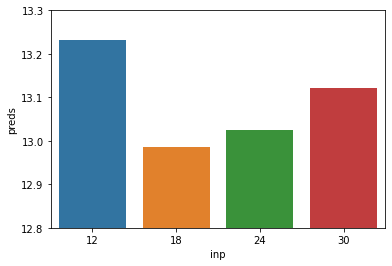

In [134]:
col = 'inp'

ensembles = df.groupby(col)['preds'].agg(concat_and_eval)
sns.barplot(x=col, y='preds', data=ensembles.reset_index())
plt.ylim([12.8, 13.3])

ensembles.sort_values()

out
8     12.950660
18    12.962551
14    12.967608
16    12.969855
12    12.972769
10    12.974654
6     12.981041
24    12.988411
20    12.990490
22    12.994319
28    13.043853
26    13.053081
30    13.053982
34    13.085979
36    13.130314
32    13.132770
Name: preds, dtype: float64

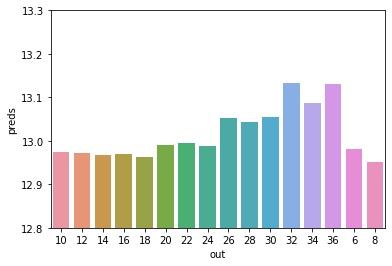

In [135]:
col = 'out'

ensembles = df.groupby(col)['preds'].agg(concat_and_eval)
sns.barplot(x=col, y='preds', data=ensembles.sort_index().reset_index())
plt.ylim([12.8, 13.3])

ensembles.sort_values()